In [ ]:
## No elimine esta celda, ya que permite actualizar los archivos .py
## sin tener que reiniciar el Kernel de Jupyter.
%load_ext autoreload
%autoreload 2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchinfo import summary
import timm
from train import *
import pandas as pd
# from transforms import *
from utils import *
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

set_seed()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
print(len(timm.list_models()))

#timm.list_models("efficientnet*")

1168


In [15]:
class Transforms:
    def __init__(self, transform: A.Compose):

        self.transform = transform

    def __call__(self, image):

        image = np.array(image)
        return self.transform(image = image)["image"]


train_transforms = A.Compose(
    [A.Resize(256, 256), A.ToFloat(), ToTensorV2()]
)
validation_transforms = A.Compose(
    [A.Resize(256, 256), A.ToFloat(), ToTensorV2()]
)


train_data = ImageFolder(
    "house_plant_species/train",
    transform = Transforms(train_transforms),
)
validation_data = ImageFolder(
    "house_plant_species/validation",
    transform = Transforms(validation_transforms),
)

print(f"Elementos en Entrenamiento: {len(train_data)}")
print(f"Elementos en Validación: {len(validation_data)}")

Elementos en Entrenamiento: 10835
Elementos en Validación: 2736


In [ ]:
print(f" {len(train_data.classes)}")
train_data.classes

['African Violet (Saintpaulia ionantha)',
 'Aloe Vera',
 'Anthurium (Anthurium andraeanum)',
 'Areca Palm (Dypsis lutescens)',
 'Asparagus Fern (Asparagus setaceus)',
 'Begonia (Begonia spp.)',
 'Bird of Paradise (Strelitzia reginae)',
 'Birds Nest Fern (Asplenium nidus)',
 'Boston Fern (Nephrolepis exaltata)',
 'Calathea',
 'Cast Iron Plant (Aspidistra elatior)',
 'Chinese Money Plant (Pilea peperomioides)',
 'Chinese evergreen (Aglaonema)',
 'Christmas Cactus (Schlumbergera bridgesii)',
 'Chrysanthemum',
 'Ctenanthe',
 'Daffodils (Narcissus spp.)',
 'Dracaena',
 'Dumb Cane (Dieffenbachia spp.)',
 'Elephant Ear (Alocasia spp.)',
 'English Ivy (Hedera helix)',
 'Hyacinth (Hyacinthus orientalis)',
 'Iron Cross begonia (Begonia masoniana)',
 'Jade plant (Crassula ovata)',
 'Kalanchoe',
 'Lilium (Hemerocallis)',
 'Lily of the valley (Convallaria majalis)',
 'Money Tree (Pachira aquatica)',
 'Monstera Deliciosa (Monstera deliciosa)',
 'Orchid',
 'Parlor Palm (Chamaedorea elegans)',
 'Peace

torch.Size([3, 256, 256])


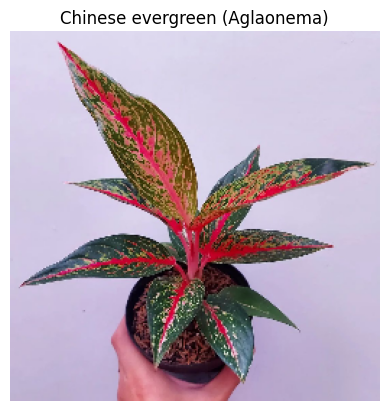

In [16]:
idx = np.random.randint(0, len(train_data))

plot_images(idx, train_data)

# Initial Trainin
Whitout Data Augmentations

In [5]:
import torchvision.models as models
import torch.nn as nn

class Alexnet(nn.Module):
    def __init__(self, backbone, output_dim, frozen=False):
        super().__init__()
        self.backbone = backbone
        # Reemplazar la última capa con Linear (mejor que LazyLinear si conoces las dimensiones)
        self.backbone.classifier[6] = nn.Linear(4096, output_dim)

        if frozen:
            # Congela todas las capas convolucionales
            for param in self.backbone.features.parameters():
                param.requires_grad = False

    def forward(self, x):
        return self.backbone(x)

# Número de clases en el problema
num_classes = len(train_data.classes)

# Instanciar el modelo con pesos preentrenados
frozen_alexnet = Alexnet(
    backbone=models.alexnet(weights="IMAGENET1K_V1"),
    output_dim=num_classes,
    frozen=True,  # Cambia a False para permitir el fine-tuning
).to(device)

# Resumen del modelo
from torchinfo import summary
summary(frozen_alexnet, input_size=(1, 3, 256, 256))


Layer (type:depth-idx)                   Output Shape              Param #
Alexnet                                  [1, 47]                   --
├─AlexNet: 1-1                           [1, 47]                   --
│    └─Sequential: 2-1                   [1, 256, 7, 7]            --
│    │    └─Conv2d: 3-1                  [1, 64, 63, 63]           (23,296)
│    │    └─ReLU: 3-2                    [1, 64, 63, 63]           --
│    │    └─MaxPool2d: 3-3               [1, 64, 31, 31]           --
│    │    └─Conv2d: 3-4                  [1, 192, 31, 31]          (307,392)
│    │    └─ReLU: 3-5                    [1, 192, 31, 31]          --
│    │    └─MaxPool2d: 3-6               [1, 192, 15, 15]          --
│    │    └─Conv2d: 3-7                  [1, 384, 15, 15]          (663,936)
│    │    └─ReLU: 3-8                    [1, 384, 15, 15]          --
│    │    └─Conv2d: 3-9                  [1, 256, 15, 15]          (884,992)
│    │    └─ReLU: 3-10                   [1, 256, 15, 15] 

In [ ]:
# Parámetros de entrenamiento
training_params = {
    "learning_rate": 1e-3,
    "batch_size": 32,
    "num_epochs": 50,
}

# Entrenar el modelo
trained_model, train_loss, val_loss = train_model(
    train_data,
    validation_data,
    architecture_name="alexnet",
    model=frozen_alexnet,
    training_params=training_params,
    num_classes=num_classes
)

# Guardar el modelo entrenado
torch.save(trained_model.state_dict(), f"alexnet_end_model.pth")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: benjaminrromo (benjaminrromo-universidad-adolfo-ib-ez). Use `wandb login --relogin` to force relogin


/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/

Epoch: 1/50 - Time: 98.22s - Train Loss: 2.1409, Train F1: 0.4262 - Validation Loss: 1.5137, Validation F1: 0.5837
Epoch: 2/50 - Time: 98.23s - Train Loss: 1.5726, Train F1: 0.5704 - Validation Loss: 1.4268, Validation F1: 0.6181
Epoch: 3/50 - Time: 95.81s - Train Loss: 1.4095, Train F1: 0.6164 - Validation Loss: 1.3395, Validation F1: 0.6396
Epoch: 4/50 - Time: 94.53s - Train Loss: 1.2676, Train F1: 0.6540 - Validation Loss: 1.2376, Validation F1: 0.6703
Epoch: 5/50 - Time: 95.84s - Train Loss: 1.1596, Train F1: 0.6836 - Validation Loss: 1.2367, Validation F1: 0.6725
Epoch: 6/50 - Time: 99.56s - Train Loss: 1.1171, Train F1: 0.6998 - Validation Loss: 1.2597, Validation F1: 0.6572
Epoch: 7/50 - Time: 94.53s - Train Loss: 1.0822, Train F1: 0.7113 - Validation Loss: 1.2905, Validation F1: 0.6590
Epoch: 8/50 - Time: 98.05s - Train Loss: 1.0200, Train F1: 0.7286 - Validation Loss: 1.3525, Validation F1: 0.6700
Epoch: 9/50 - Time: 96.86s - Train Loss: 0.9834, Train F1: 0.7422 - Validation L

elapsed_time,▇▇▄▂▄▂▇▅▃▄▃▇▄▄▆▁█▄▁▃▂▄▃▅▂▃▆▁▂▆▆▇▁▃▄▃▅▃▂▆
epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_f1,▁▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇███████████
train_loss,█▆▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▃▄▆▆▅▆▆▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇█▇▆▇▇▇▇▇▇▇▇▇█▇
val_loss,▃▃▁▁▁▂▁▂▃▂▃▃▃▂▃▄▄▄▄▅▅▄▅▅▄▆▇▅▇▅▇▆█▇▆█▆▇▇▇
elapsed_time,97.44021
epoch,50
train_f1,0.90937
train_loss,0.45484
val_f1,0.69956


In [ ]:
# Parámetros de entrenamiento
training_params = {
    "learning_rate": 1e-3,
    "batch_size": 32,
    "num_epochs": 15,
}
sample_image, _ = train_data[0]  # Accede al primer elemento del dataset
in_channels = sample_image.shape[0]  # Dimensión del canal (e.g., 3 para RGB)
print(f"Number of input channels: {in_channels}")
# Dataset (asegúrate de definir correctamente `train_data` y `val_data`)
num_classes = len(train_data.classes)
# Crear el modelo usando timm
# Crear el modelo especificando los canales de entrada
model_resnet34 = timm.create_model(
    "resnet18",
    pretrained=True,
    num_classes=num_classes,
    in_chans=in_channels,
)
# Entrenar el modelo
trained_model, train_loss, val_loss = train_model(
    train_data,
    validation_data,
    architecture_name="resnet18_2",
    model=model_resnet34,
    training_params=training_params,
    num_classes=num_classes
)

Number of input channels: 3


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: benjaminrromo (benjaminrromo-universidad-adolfo-ib-ez). Use `wandb login --relogin` to force relogin


/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/

Epoch: 1/15 - Time: 119.46s - Train Loss: 1.3915, Train F1: 0.6424 - Validation Loss: 0.8108, Validation F1: 0.7657
Epoch: 2/15 - Time: 115.17s - Train Loss: 0.4118, Train F1: 0.8767 - Validation Loss: 0.5428, Validation F1: 0.8395
Epoch: 3/15 - Time: 113.00s - Train Loss: 0.2200, Train F1: 0.9325 - Validation Loss: 0.5635, Validation F1: 0.8443
Epoch: 4/15 - Time: 120.54s - Train Loss: 0.1392, Train F1: 0.9567 - Validation Loss: 0.4941, Validation F1: 0.8629
Epoch: 5/15 - Time: 117.89s - Train Loss: 0.0878, Train F1: 0.9743 - Validation Loss: 0.5928, Validation F1: 0.8472
Epoch: 6/15 - Time: 104.58s - Train Loss: 0.0950, Train F1: 0.9717 - Validation Loss: 0.5425, Validation F1: 0.8648
Epoch: 7/15 - Time: 118.25s - Train Loss: 0.0760, Train F1: 0.9766 - Validation Loss: 0.5411, Validation F1: 0.8604
Epoch: 8/15 - Time: 116.46s - Train Loss: 0.0738, Train F1: 0.9790 - Validation Loss: 0.6430, Validation F1: 0.8461
Epoch: 9/15 - Time: 118.92s - Train Loss: 0.0882, Train F1: 0.9736 - Val

elapsed_time,▇▆▅▇▆▃▆▆▇█▅▁▂▆▄
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_f1,▁▆▇▇███████████
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▆▆▇▆█▇▆▇▇▅▆▆█▇
val_loss,█▂▃▁▃▂▂▄▅▄▇▅▆▄▅
elapsed_time,108.16053
epoch,15
train_f1,0.98514
train_loss,0.0502
val_f1,0.85161


In [7]:
# Parámetros de entrenamiento
training_params = {
    "learning_rate": 1e-3,
    "batch_size": 32,
    "num_epochs": 15,
}
sample_image, _ = train_data[0]  # Accede al primer elemento del dataset
in_channels = sample_image.shape[0]  # Dimensión del canal (e.g., 3 para RGB)
print(f"Number of input channels: {in_channels}")
# Dataset (asegúrate de definir correctamente `train_data` y `val_data`)
num_classes = len(train_data.classes)
# Crear el modelo usando timm
# Crear el modelo especificando los canales de entrada
model_resnet34 = timm.create_model(
    "resnet34",
    pretrained=True,
    num_classes=num_classes,
    in_chans=in_channels,
)
# Entrenar el modelo
trained_model, train_loss, val_loss = train_model(
    train_data,
    validation_data,
    architecture_name="resnet34",
    model=model_resnet34,
    training_params=training_params,
    num_classes=num_classes
    
)

Number of input channels: 3


/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/

Epoch: 1/15 - Time: 135.84s - Train Loss: 1.4056, Train F1: 0.6322 - Validation Loss: 0.6160, Validation F1: 0.8191
Epoch: 2/15 - Time: 137.37s - Train Loss: 0.4042, Train F1: 0.8787 - Validation Loss: 0.4917, Validation F1: 0.8622
Epoch: 3/15 - Time: 136.69s - Train Loss: 0.2280, Train F1: 0.9314 - Validation Loss: 0.5070, Validation F1: 0.8589
Epoch: 4/15 - Time: 137.53s - Train Loss: 0.1527, Train F1: 0.9515 - Validation Loss: 0.4757, Validation F1: 0.8681
Epoch: 5/15 - Time: 136.71s - Train Loss: 0.1461, Train F1: 0.9524 - Validation Loss: 0.5222, Validation F1: 0.8681
Epoch: 6/15 - Time: 138.05s - Train Loss: 0.0987, Train F1: 0.9683 - Validation Loss: 0.5366, Validation F1: 0.8611
Epoch: 7/15 - Time: 137.38s - Train Loss: 0.0801, Train F1: 0.9760 - Validation Loss: 0.5631, Validation F1: 0.8666
Epoch: 8/15 - Time: 136.70s - Train Loss: 0.0903, Train F1: 0.9718 - Validation Loss: 0.6091, Validation F1: 0.8458
Epoch: 9/15 - Time: 137.11s - Train Loss: 0.0670, Train F1: 0.9792 - Val

elapsed_time,▁▅▃▅▃▇▅▃▄▇▄▆▅█▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_f1,▁▆▇▇▇██████████
train_loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁
val_f1,▁▅▅▆▆▅▆▄▇▆▆█▆▆█
val_loss,█▂▃▁▄▄▅█▄▅▆▁▄▆▃
elapsed_time,135.88213
epoch,15
train_f1,0.98533
train_loss,0.05159
val_f1,0.88523


# Training with Data Augmentation

In [ ]:
import torchvision.models as models
import torch.nn as nn

class Alexnet(nn.Module):
    def __init__(self, backbone, output_dim, frozen=False):
        super().__init__()
        self.backbone = backbone
        # Reemplazar la última capa con Linear (mejor que LazyLinear si conoces las dimensiones)
        self.backbone.classifier[6] = nn.Linear(4096, output_dim)

        if frozen:
            # Congela todas las capas convolucionales
            for param in self.backbone.features.parameters():
                param.requires_grad = False

    def forward(self, x):
        return self.backbone(x)

# Número de clases en el problema
num_classes = len(train_data.classes)

# Instanciar el modelo con pesos preentrenados
frozen_alexnet_aug = Alexnet(
    backbone=models.alexnet(weights="IMAGENET1K_V1"),
    output_dim=num_classes,
    frozen=True,  # Cambia a False para permitir el fine-tuning
).to(device)

# Resumen del modelo
from torchinfo import summary
summary(frozen_alexnet_aug, input_size=(1, 3, 256, 256))


Layer (type:depth-idx)                   Output Shape              Param #
Alexnet                                  [1, 47]                   --
├─AlexNet: 1-1                           [1, 47]                   --
│    └─Sequential: 2-1                   [1, 256, 7, 7]            --
│    │    └─Conv2d: 3-1                  [1, 64, 63, 63]           (23,296)
│    │    └─ReLU: 3-2                    [1, 64, 63, 63]           --
│    │    └─MaxPool2d: 3-3               [1, 64, 31, 31]           --
│    │    └─Conv2d: 3-4                  [1, 192, 31, 31]          (307,392)
│    │    └─ReLU: 3-5                    [1, 192, 31, 31]          --
│    │    └─MaxPool2d: 3-6               [1, 192, 15, 15]          --
│    │    └─Conv2d: 3-7                  [1, 384, 15, 15]          (663,936)
│    │    └─ReLU: 3-8                    [1, 384, 15, 15]          --
│    │    └─Conv2d: 3-9                  [1, 256, 15, 15]          (884,992)
│    │    └─ReLU: 3-10                   [1, 256, 15, 15] 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.5877123].


Elementos en Entrenamiento: 10835
Elementos en Validación: 2736
torch.Size([3, 256, 256])


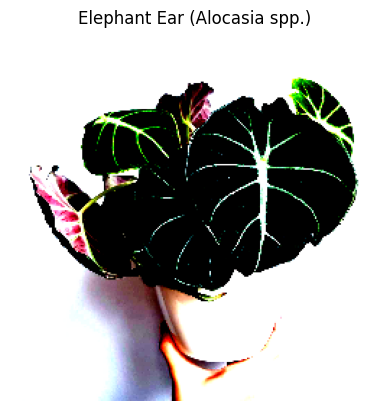

In [ ]:

# Configuración para entrenamiento
selected_train_transforms = [
    "resize",
    "horizontal_flip",
    "normalize"
]

train_data, validation_data = transforming(selected_train_transforms)

idx = np.random.randint(0, len(train_data))

plot_images(idx, train_data)

In [ ]:
# Parámetros de entrenamiento
training_params = {
    "learning_rate": 1e-3,
    "batch_size": 32,
    "num_epochs": 10,
}

# Entrenar el modelo
trained_model, train_loss, val_loss = train_model(
    train_data,
    validation_data,
    architecture_name="alexnet_aug",
    model=frozen_alexnet_aug,
    training_params=training_params,
    num_classes=num_classes
)

# Guardar el modelo entrenado
torch.save(trained_model.state_dict(), f"alexnet_aug_end_model.pth")

NameError: name 'frozen_alexnet_aug' is not defined

In [ ]:
# Parámetros de entrenamiento
training_params = {
    "learning_rate": 1e-3,
    "batch_size": 32,
    "num_epochs": 15,
}
sample_image, _ = train_data[0]  # Accede al primer elemento del dataset
in_channels = sample_image.shape[0]  # Dimensión del canal (e.g., 3 para RGB)
print(f"Number of input channels: {in_channels}")
# Dataset (asegúrate de definir correctamente `train_data` y `val_data`)
num_classes = len(train_data.classes)
# Crear el modelo usando timm
# Crear el modelo especificando los canales de entrada
model_resnet18_aug = timm.create_model(
    "resnet18",
    pretrained=True,
    num_classes=num_classes,
    in_chans=in_channels,
)
# Entrenar el modelo
trained_model, train_loss, val_loss = train_model(
    train_data,
    validation_data,
    architecture_name="resnet_18_aug",
    model=model_resnet18_aug,
    training_params=training_params,
    num_classes=num_classes
)

Number of input channels: 3


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: benjaminrromo (benjaminrromo-universidad-adolfo-ib-ez). Use `wandb login --relogin` to force relogin


/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/python3.10/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/home/notvenja24/Descargas/Deep Learning/Tarea03_Deep_learning/venv/lib/

Epoch: 1/15 - Time: 163.03s - Train Loss: 1.4026, Train F1: 0.6375 - Validation Loss: 0.6888, Validation F1: 0.8041
Epoch: 2/15 - Time: 160.69s - Train Loss: 0.4592, Train F1: 0.8620 - Validation Loss: 0.5739, Validation F1: 0.8355
Epoch: 3/15 - Time: 163.11s - Train Loss: 0.2880, Train F1: 0.9133 - Validation Loss: 0.4779, Validation F1: 0.8688
Epoch: 4/15 - Time: 169.61s - Train Loss: 0.1947, Train F1: 0.9389 - Validation Loss: 0.5886, Validation F1: 0.8370
Epoch: 5/15 - Time: 139.97s - Train Loss: 0.1488, Train F1: 0.9535 - Validation Loss: 0.5182, Validation F1: 0.8589
Epoch: 6/15 - Time: 126.23s - Train Loss: 0.1245, Train F1: 0.9612 - Validation Loss: 0.4779, Validation F1: 0.8706
Epoch: 7/15 - Time: 123.01s - Train Loss: 0.1005, Train F1: 0.9708 - Validation Loss: 0.5447, Validation F1: 0.8670
Epoch: 8/15 - Time: 133.63s - Train Loss: 0.0988, Train F1: 0.9702 - Validation Loss: 0.5328, Validation F1: 0.8648
